In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_aesara as sun


## Generate Data
from scipy.integrate import ode
alpha  = 1
beta=0.1
gamma=1.5
delta=0.75 * 0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha*state[0] -   beta*state[0]*state[1],
                  -gamma*state[1] + delta*state[0]*state[1]])

t = np.linspace(0, 24,  50)              # time
X0 = np.array([10, 5])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y

np.random.seed(0)
yobs = X.T * np.random.lognormal(mean=0,sigma=0.1,size=X.T.shape)  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
times = t
print(yobs.std(axis=0))
yobs_norm = yobs / yobs.std(axis=0)



## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 + p.pn[10] - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 + p.pn[11] - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}


d = 12

model_sunode = pm.Model()

with model_sunode:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    xi = pm.Bernoulli('xi', 0.8, shape=d)
    pnss = pm.Deterministic('pnss', pn * xi)
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pnss,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

with model_sunode:

    start = pm.find_MAP()

    # Initialize parameters with least squares and all other values with MAP
    inp = yobs_norm
    u = inp[:,0]
    v = inp[:,1]

    θ = np.array([u,v,u*v,u**2,v**2,np.ones(u.shape)]).T

    import pysindy as ps
    from pysindy.differentiation import SmoothedFiniteDifference
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    dx = sfd(inp)

    guess = np.linalg.lstsq(θ,dx)[0]
    
    print('Initialization')
    print(guess)

    start['pn'] = guess.flatten()
    start['pnss'] = start['pn']
    start['xi'] = np.ones(start['pn'].shape).astype(int)
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])

    trace = pm.backends.load_trace('../saved_models/synthetic_ss_12param_50_data' + '.trace',model_sunode)

[10.94487607  6.80885278]



[CVODEA ERROR]  CVodeF
  At t = 0.94535, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.948706, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.94535, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.948706, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.94535, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.948706, mxstep steps taken before reaching tout.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0




Initialization
[[-0.00307423  0.08648512]
 [-0.74981738 -0.51535495]
 [-0.12003139  0.20955827]
 [ 0.04790503  0.02845726]
 [ 0.12110972  0.02965002]
 [ 0.84606363 -0.19116056]]


/tmp/ipykernel_1883065/3856019386.py:95: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  guess = np.linalg.lstsq(θ,dx)[0]


In [2]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marsgao/miniconda3/envs/bsindy/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/marsgao/miniconda3/envs/bsindy/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pn[0],0.819,0.419,0.071,1.291,0.153,0.113,6.0,56.0,1.29
pn[1],-0.077,1.187,-2.443,2.232,0.045,0.032,57.0,937.0,1.04
pn[2],0.063,1.158,-2.204,2.717,0.043,0.054,551.0,339.0,1.04
pn[3],-1.366,0.219,-1.688,-0.901,0.099,0.075,7.0,32.0,1.21
pn[4],-0.618,0.181,-0.821,-0.155,0.080,0.060,8.0,61.0,1.18
pn[5],0.732,0.142,0.422,0.940,0.065,0.049,6.0,30.0,1.22
pn[6],0.004,1.062,-2.309,2.139,0.060,0.060,253.0,162.0,1.27
pn[7],0.138,1.126,-2.257,2.352,0.026,0.041,1023.0,1765.0,1.16
pn[8],-0.027,1.168,-2.443,2.256,0.018,0.051,1373.0,1338.0,1.11
pn[9],0.278,1.746,-2.505,5.396,0.224,0.199,109.0,31.0,1.01


/tmp/ipykernel_1883065/1965566635.py:4: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot((trace['pnss']).T, kind='ridgeplot', colors='green', ridgeplot_overlap=10, ax=ax)


<bound method Axes.plot of <AxesSubplot:title={'center':'Spike and Slab'}, xlabel='Coefficient value'>>

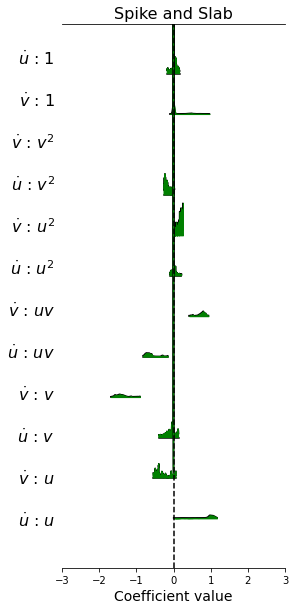

In [3]:
plt.figure(figsize=(4,10))
ax = plt.subplot(1,1,1)
ax.plot([0, 0], [-0.05, 0.5], 'k--')
pm.forestplot((trace['pnss']).T, kind='ridgeplot', colors='green', ridgeplot_overlap=10, ax=ax)
#ax.set_title('')
#ax.set_xlabel('Coefficient value')
#ax.set_ylabel('Coefficient')
ax.set_xlim(-3.0, 3.0)
ax.set_ylim(-0.05, 0.5)
ax.set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85)
ax.set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
                   r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
                   r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
                   r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
                   r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
                   r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'], fontsize=16)

ax.set_xlabel('Coefficient value', fontsize=14)
plt.title('Spike and Slab', fontsize=16)
# plt.yticks([])    
ax.plot

In [4]:
synthetic_ss_12param = trace

Mean and Std
-0.03043766103789285 0.08561360907122584
Mean and Std
0.02607013787778859 0.08065197135387187
Mean and Std
-0.6178815733387514 0.18193857356879056
Mean and Std
-0.04377552538493146 0.15978241111054586
Mean and Std
0.8213271906992613 0.36522854423381357
Mean and Std
0.19773070621018732 0.3435682108019951
Mean and Std
-0.0001737337910134293 0.02180813167239231
Mean and Std
0.04597853693292239 0.09598655166726479
Mean and Std
0.7323529910374237 0.14200902149337208
Mean and Std
-1.366374191560113 0.2193909846666153
Mean and Std
-0.08812177806285718 0.20522096241997861
Mean and Std
0.004479220564681568 0.09949751596153934
0.001223317449916217
-0.0009550926837289531
-0.6987542820415783
0.005214577707203016
1.0213626090404566
-0.007123680860490089
0.001471920412922878
0.00042083208026874597
0.7928761485006047
-1.4422831399110287
0.003063847360652572
0.0006871149003557786


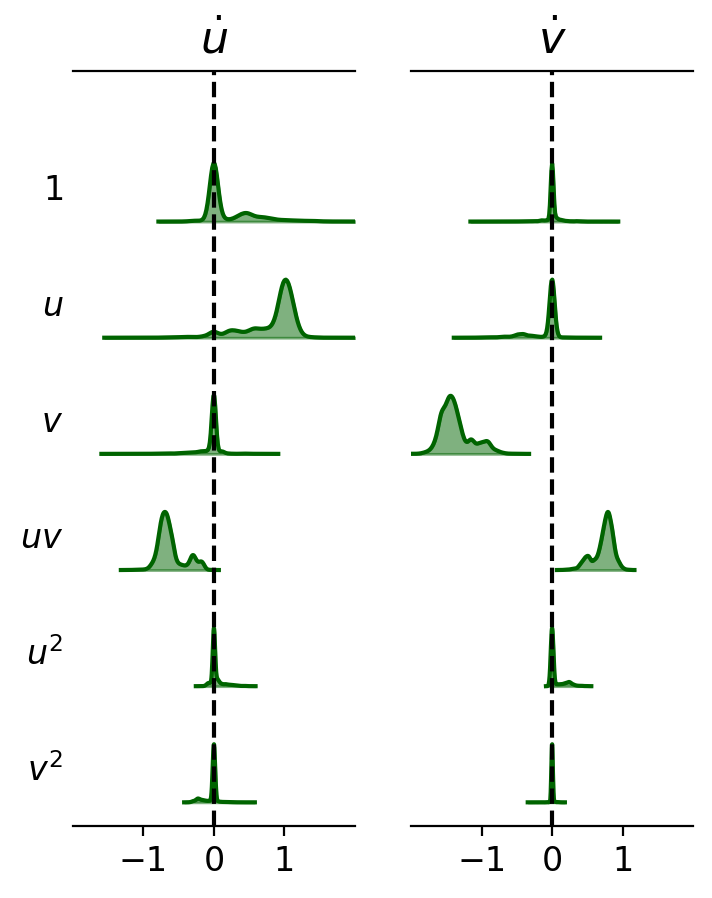

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (synthetic_ss_12param['pnss'].T[::2,:][[5,0,1,2,3,4][::-1],:], synthetic_ss_12param['pnss'].T[1::2,:][[5,0,1,2,3,4][::-1],:])


colors = ['darkgreen','darkgreen']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
#         sns.kdeplot(data=v + np.random.randn(*v.shape) * 0.0002,color=colors[sbplt],ax=ax[sbplt])
        sns.kdeplot(data=v + np.random.randn(*v.shape) * 0.01,color=colors[sbplt],ax=ax[sbplt])
        print("Mean and Std")
        print(np.mean(v + np.random.randn(*v.shape) * 0.01), np.std(v + np.random.randn(*v.shape) * 0.01))
       # if i==5 and sbplt==1:
       #     sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$1$',
                       r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$'][::-1], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

    
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.show()

In [ ]:
# Experiment of 50 data run result
# y^2: Mean and Std
# -0.03011262853823575 0.13274055531874865
# x^2: Mean and Std
# 0.02782060891550885 0.12811266229840673
# xy: Mean and Std
# -0.6180017276410006 0.2081867091704939
# y: Mean and Std
# -0.043046540090504196 0.18926161864077062
# x: Mean and Std
# 0.8209342601018352 0.37761300029035044
# 1: Mean and Std
# 0.19894274307056176 0.35581961445975036
# y^2: Mean and Std
# 0.0002550574365983991 0.10207192269105426
# x^2: Mean and Std
# 0.04526023585768801 0.13841926423125506
# xy: Mean and Std
# 0.734185915228724 0.17349561298662763
# y: Mean and Std
# -1.3657182262235812 0.24169419912358786
# x: Mean and Std
# -0.0879427090484641 0.2289075182762312
# 1: Mean and Std
# 0.003961118844513681 0.14037074769821647